In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [2]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [3]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

In [4]:
X_test.shape
y.shape

(42000, 1)

In [13]:
import tensorflow as tf

input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))


weight_input_hidden = tf.Variable(tf.random_normal(shape=(int(input_.shape[1]), 128), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_input_hidden = tf.Variable(tf.zeros(weight_input_hidden.shape[1]))


#weight_hidden1_hidden2 = tf.Variable(tf.random_normal(shape=(int(weight_input_hidden1.shape[1]), 16), mean=0.0, stddev=0.01, dtype=tf.float32))
#bias_hidden1_hidden2 = tf.Variable(tf.zeros(weight_hidden1_hidden2.shape[1]))

weight_hidden_output = tf.Variable(tf.random_normal(shape=(128, 10), mean=0.0, stddev=0.01, dtype=tf.float32))
bias_hidden_output = tf.Variable(tf.zeros(weight_hidden_output.shape[1]))

print(input_)
print(labels)
print(weight_input_hidden)
print(bias_input_hidden)
print(weight_hidden_output)
print(bias_hidden_output)

weight_dict = {'layer0': weight_input_hidden, 'layer1': weight_hidden_output}
bias_dict = {'layer0': bias_input_hidden, 'layer1': bias_hidden_output}

Tensor("Placeholder_2:0", shape=(?, 784), dtype=float32)
Tensor("Placeholder_3:0", shape=(?, 1), dtype=int32)
<tf.Variable 'Variable_4:0' shape=(784, 128) dtype=float32_ref>
<tf.Variable 'Variable_5:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Variable_6:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>


In [14]:
def nn():
    hidden_input = tf.add(tf.matmul(input_, weight_dict['layer0']), bias_dict['layer0'])
    hidden_output = tf.nn.relu(hidden_input)
    
    output = tf.add(tf.matmul(hidden_output, weight_dict['layer1']), bias_dict['layer1'])
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)
    
    return cost, optimizer, output

In [15]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [16]:
cost, optimizer, output = nn()

In [17]:
from sklearn.metrics import accuracy_score

# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 250
batch_size = 64
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #plt.ion()
    # Training cycle
    for epoch in range(epochs):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, feed_dict={input_:x, labels:y})
            
        c = sess.run(cost, feed_dict={input_: x, labels: y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        
        # Find train accuracy
        y_predicted_train_fold = np.argmax(output.eval(feed_dict={input_: X_train_fold, labels: y_train_fold}), 1)
        current_train_acc = accuracy_score(y_true=y_train_fold, y_pred=y_predicted_train_fold)
        
        train_accuracy.append(current_train_acc)
        
        print("Train Accuracy:", current_train_acc)
        
        # Find the validation accuracy
        y_predicted_val_fold = np.argmax(output.eval(feed_dict={input_: X_val_fold, labels: y_val_fold}), 1)
        current_val_acc = accuracy_score(y_true=y_val_fold, y_pred=y_predicted_val_fold)
        
        val_accuracy.append(current_val_acc)
        
        print("Validation Accuracy:", current_val_acc)
        print()
        
        #plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
        #plt.show()
    
    print("Optimization Finished!")
    
    
    # Find test accuracy
    y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test}), 1)
    print("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_predicted_test))

Epoch: 0001 cost= 0.032259341
Train Accuracy: 0.785832730983
Validation Accuracy: 0.78231292517

Epoch: 0002 cost= 0.017972417
Train Accuracy: 0.836089969812
Validation Accuracy: 0.840816326531

Epoch: 0003 cost= 0.025359616
Train Accuracy: 0.855563586887
Validation Accuracy: 0.850340136054

Epoch: 0004 cost= 0.006692687
Train Accuracy: 0.865215357796
Validation Accuracy: 0.865136054422

Epoch: 0005 cost= 0.011219754
Train Accuracy: 0.869552276883
Validation Accuracy: 0.869727891156

Epoch: 0006 cost= 0.020999258
Train Accuracy: 0.890471533654
Validation Accuracy: 0.891326530612

Epoch: 0007 cost= 0.008208629
Train Accuracy: 0.882052808368
Validation Accuracy: 0.88112244898

Epoch: 0008 cost= 0.004690687
Train Accuracy: 0.876610400102
Validation Accuracy: 0.867006802721

Epoch: 0009 cost= 0.003471459
Train Accuracy: 0.878183596241
Validation Accuracy: 0.877210884354

Epoch: 0010 cost= 0.033329006
Train Accuracy: 0.897232025171
Validation Accuracy: 0.899319727891

Epoch: 0011 cost= 0.04

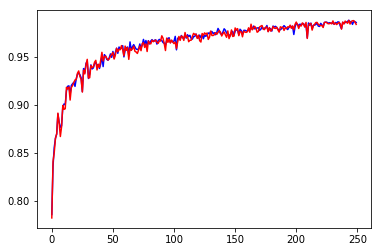

In [18]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

array([[1245,    0,    0,    1,    0,    3,    8,    1,    3,    2],
       [   0, 1398,    2,    0,    1,    2,    2,    2,    2,    1],
       [  10,    5, 1162,    7,    4,    6,    5,   15,   10,    2],
       [   5,    6,   12, 1253,    0,   19,    1,    9,    8,    4],
       [   1,    4,    1,    0, 1153,    0,    2,    3,    2,   18],
       [   6,    3,    1,    9,    0, 1101,    5,    0,    5,    5],
       [   7,    2,    2,    0,    5,    9, 1200,    1,    1,    0],
       [   3,    1,    9,    1,    5,    2,    0, 1299,    1,   11],
       [   1,   35,    7,    6,    3,   13,    7,    3, 1148,   12],
       [   4,    5,    2,    9,   22,    5,    0,   41,    1, 1183]])

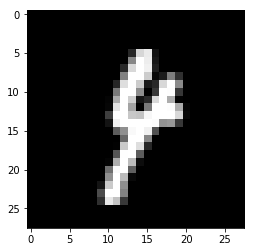

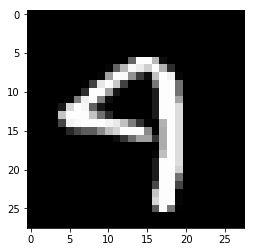

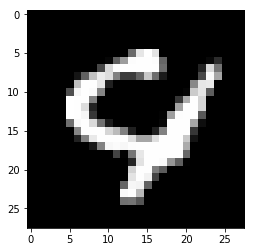

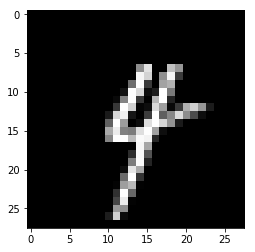

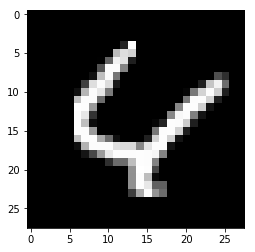

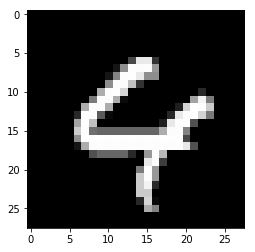

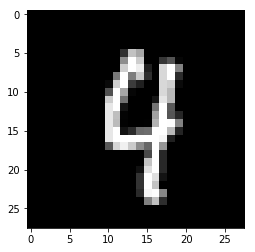

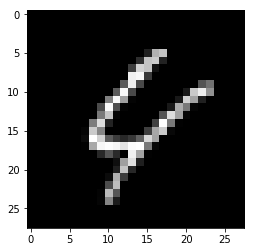

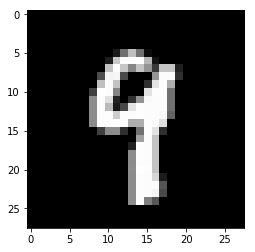

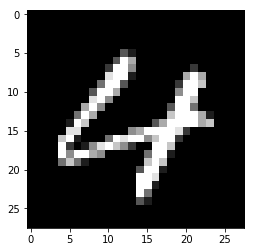

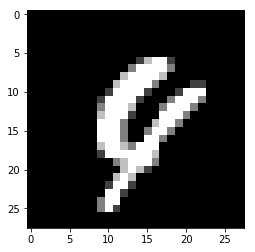

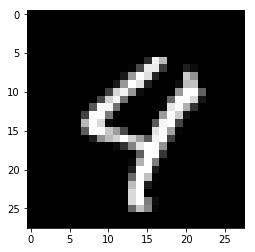

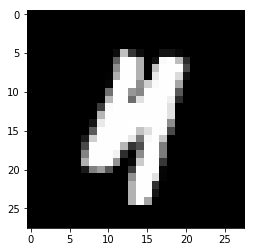

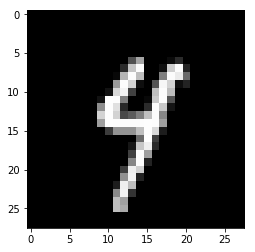

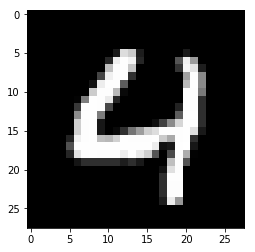

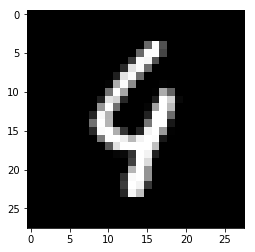

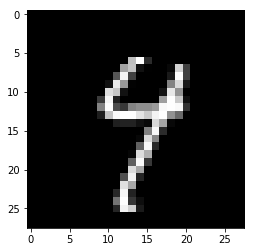

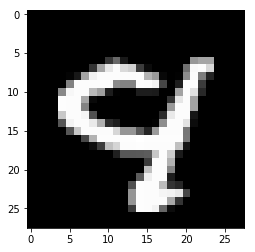

In [20]:
indices = np.where(np.logical_and(y_predicted_test == 9, y_test.squeeze() == 4))[0]
for i in indices:
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()